In [1]:
import warnings
import numpy as np
import pandas as pd
import gensim as gs
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
warnings.filterwarnings('ignore')

In [3]:
read_file = pd.read_csv('dataset/train_dataset_random_1_5', delimiter=',', header=None)
train_dataset = read_file.iloc[:,:].values

In [4]:
read_file = pd.read_csv('dataset/validation_dataset_random_1_5', delimiter=',', header=None)
validation_dataset = read_file.iloc[:,:].values

In [2]:
embedding_model = gs.models.FastText.load_fasttext_format('pre_trained_models/cc.en.300.bin')

In [5]:
MAX_PAD = 9

def sequence_padding(X_DIM, value):
    
    value_padding = np.pad(value, ((0,MAX_PAD - X_DIM),(0,0)), 'constant')
    
    return value_padding

In [6]:
def create_embedding(value):

    value = tknzr.tokenize(str(value))
    
    if len(value) < MAX_PAD:
        
        embedding = embedding_model.wv[value]
        
        padding_embedding = sequence_padding(embedding.shape[0],embedding)
        
        return padding_embedding
        
    else:
        
        embedding = embedding_model.wv[value[0:MAX_PAD]]
        
        return embedding

In [7]:
train_article_title = []
train_article_description = []
train_table_title = []
train_label = []

for articleID, articleTitle, meta_description, keywords, tableID, tableTitle, match in tqdm(train_dataset):
    
    train_article_title.append(create_embedding(articleTitle))
    #train_article_description.append(create_embedding(meta_description))  
    train_table_title.append(create_embedding(tableTitle))
    train_label.append(match)

100%|██████████| 60756/60756 [00:37<00:00, 1610.33it/s]


In [8]:
train_article_title = np.array(train_article_title)
#train_article_description = np.array(train_article_description)
train_table_title = np.array(train_table_title)
train_label = np.array(train_label)

In [9]:
train_article_title.shape

(60756, 9, 300)

In [10]:
validation_article_title = []
validation_article_description = []
validation_table_title = []
validation_label = []

for articleID, articleTitle, meta_description, keywords, tableID, tableTitle, match in tqdm(validation_dataset):
    
    validation_article_title.append(create_embedding(articleTitle))
    #validation_article_description.append(create_embedding(meta_description))
    validation_table_title.append(create_embedding(tableTitle))  
    validation_label.append(match)

100%|██████████| 3179/3179 [00:01<00:00, 2368.20it/s]


In [11]:
validation_article_title = np.array(validation_article_title)
#validation_article_description = np.array(validation_article_description)
validation_table_title = np.array(validation_table_title)
validation_label = np.array(validation_label)

In [12]:
validation_article_title.shape

(3179, 9, 300)

In [13]:
def coattention_method(query, document):
    
    transpose_document = tf.transpose(document,perm=[0, 2, 1])
    
    affinity = tf.matmul(query,transpose_document)

    #transpose_affinity = tf.transpose(affinity, perm=[0, 2, 1])
    
    #row_normalized = tf.nn.softmax(affinity, axis=1)
    
    #column_normalized = tf.nn.softmax(transpose_affinity, axis=1)
    
    #context_vector = tf.matmul(row_normalized,document)
    
    #concatenate_context_query = tf.concat([context_vector,query],axis=-1)
     
    #context_document = tf.matmul(column_normalized,concatenate_context_query)
    
    #co_attention = tf.concat([document,context_document],axis=-1)
    
    return affinity

In [14]:
def attention_model():
    
    article_title = tf.keras.Input(shape=(9,300), dtype='float32')
    #article_description = tf.keras.Input(shape=(40,300), dtype='float32')
    table_title = tf.keras.Input(shape=(9,300), dtype='float32')
    
    encodding_article_title = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(article_title)
    #encodding_article_description = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(article_description)
    encodding_table_title = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))(table_title)
    
    attention_title_title = coattention_method(encodding_article_title,encodding_table_title)
    #attention_title_description = coattention_method(encodding_article_description,encodding_table_title)
    
    flatten1 = tf.keras.layers.Flatten()(attention_title_title)
    #flatten2 = tf.keras.layers.Flatten()(attention_title_description)
    
    #concatenated = tf.keras.layers.Concatenate()([flatten1,flatten2])
    
    prediction = tf.keras.layers.Dense(1,activation='sigmoid')(flatten1)
    
    model = tf.keras.Model(inputs=[article_title,table_title],outputs=prediction)
    
    return model

In [15]:
model = attention_model()

In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model, to_file='test.png')

In [16]:
model.compile(loss="binary_crossentropy",optimizer="adam", metrics=['accuracy'])

In [ ]:
# checkpoint = tf.keras.callbacks.ModelCheckpoint('attention.h5', monitor='val_acc',verbose=1, save_the_best_only=True, mode='max')
# callbacks_list = [checkpoint]

In [17]:
history = model.fit([train_article_title, train_table_title], train_label, 
          epochs=10, 
          batch_size=32, 
          validation_data=([validation_article_title, validation_table_title], validation_label))
          #callbacks=callbacks_list)

Train on 60756 samples, validate on 3179 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
60756/60756 [==============================] - 199s 3ms/sample - loss: 0.3244 - accuracy: 0.8629 - val_loss: 0.2411 - val_accuracy: 0.8956
Epoch 2/10
60756/60756 [==============================] - 152s 2ms/sample - loss: 0.1968 - accuracy: 0.9186 - val_loss: 0.1839 - val_accuracy: 0.9217
Epoch 3/10
60756/60756 [==============================] - 145s 2ms/sample - loss: 0.1342 - accuracy: 0.9470 - val_loss: 0.1665 - val_accuracy: 0.9346
Epoch 4/10
60756/60756 [==============================] - 139s 2ms/sample - loss: 0.0915 - accuracy: 0.9651 - val_loss: 0.1679 - val_accuracy: 0.9368
Epoch 5/10
60756/60756 [==============================] - 138s 2ms/sample - loss: 0.0618 - accuracy: 0.9773 - val_loss: 0.1650 - val_accuracy: 0.9450
Epoch 6/10
60756/60756 [==============================] - 140s 2ms/sample - loss: 0.0426 - accuracy: 0.9847

In [18]:
model.save('attention_model_random.h5')

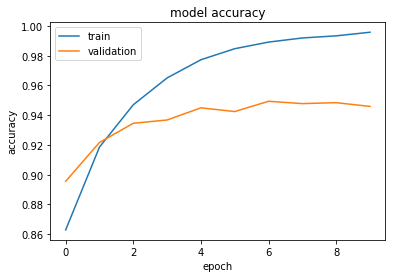

In [19]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

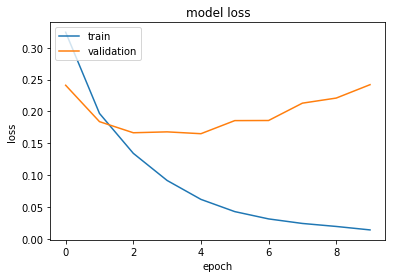

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
y_prob = model.predict([validation_article_title,validation_table_title])
y_prob = (y_prob > 0.5).astype(np.int)
accuracy_score(label_validation, y_prob)

NameError: name 'label_validation' is not defined

In [22]:
classes=[0,1]
con_mat = tf.math.confusion_matrix(labels=validation_label, predictions=y_prob).numpy()
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)

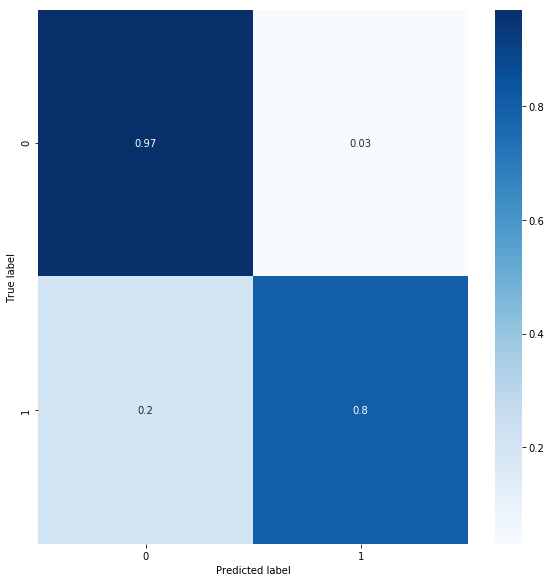

In [23]:
import seaborn as sns;
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()